# <font color='blue'>Data Science Challenge @ ITA 2022</font>
# <font color='blue'>Equipe DIOMGIS</font>

## <font color='blue'>Fase 1</font>

### <font color='blue'>Predição de pregões futuros de ativos que compõem o índice SP500.</font>

![title](data\image\logo.jpeg)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [2]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# Bibliotecas e Frameworks

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import *
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from keras.wrappers.scikit_learn import KerasRegressor
from tensorboard import notebook
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from time import time
from datetime import datetime
import os

In [4]:
# Versões dos pacotes usados neste jupyter notebook

%reload_ext watermark
%watermark -a "Equipe DIOMGIS" --iversions

Author: Equipe DIOMGIS

keras            : 2.10.0
numpy            : 1.22.3
tensorboard      : 2.10.0
seaborn          : 0.11.2
pandas           : 1.4.2
pandas_datareader: 0.10.0
matplotlib       : 3.5.1
tensorflow       : 2.10.0



In [5]:
sns.set_style('whitegrid')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
# Parametros fixos de treinamento

verbose = 2
seed = 25
steps = 30
epochs = 10
batch_size = 32
nKFold = 5

np.random.seed(seed)

In [7]:
#Confirma se o TensorFlow pode acessar a GPU

device_name = tf.test.gpu_device_name()
if not device_name:
    raise SystemError('GPU device not found')
    
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
# Estado da GPU

# !nvidia-smi

### Download dos Dados (Execute somente na primeira vez que rodar o Notebook)

In [9]:
forecast = ['2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27', '2022-10-28', 
            '2022-10-31', '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04', 
            '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10', '2022-11-11',
            '2022-11-14', '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18']

In [10]:

ativos = ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT',
       'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES',
       'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL',
       'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN',
       'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE',
       'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA',
       'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB',
       'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO',
       'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB',
       'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG',
       'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX',
       'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF',
       'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO',
       'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS',
       'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI',
       'DHR', 'DIS', 'DISH', 'DLR', 'DLTR', 'DOV', 'DOW', 'DPZ', 'DRI',
       'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'DXCM', 'EA', 'EBAY', 'ECL',
       'ED', 'EFX', 'EIX', 'EL', 'ELV', 'EMN', 'EMR', 'ENPH', 'EOG',
       'EPAM', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETN', 'ETR', 'ETSY',
       'EVRG', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST',
       'FBHS', 'FCX', 'FDS', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FITB',
       'FLT', 'FMC', 'FOX', 'FOXA', 'FRC', 'FRT', 'FTNT', 'FTV', 'GD',
       'GE', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GNRC', 'GOOG', 'GOOGL',
       'GPC', 'GPN', 'GRMN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HCA',
       'HD', 'HES', 'HIG', 'HII', 'HLT', 'HOLX', 'HON', 'HPE', 'HPQ',
       'HRL', 'HSIC', 'HST', 'HSY', 'HUM', 'HWM', 'IBM', 'ICE', 'IDXX',
       'IEX', 'IFF', 'ILMN', 'INCY', 'INTC', 'INTU', 'INVH', 'IP', 'IPG',
       'IQV', 'IR', 'IRM', 'ISRG', 'IT', 'ITW', 'IVZ', 'J', 'JBHT', 'JCI',
       'JKHY', 'JNJ', 'JNPR', 'JPM', 'K', 'KDP', 'KEY', 'KEYS', 'KHC',
       'KIM', 'KLAC', 'KMB', 'KMI', 'KMX', 'KO', 'KR', 'L', 'LDOS', 'LEN',
       'LH', 'LHX', 'LIN', 'LKQ', 'LLY', 'LMT', 'LNC', 'LNT', 'LOW',
       'LRCX', 'LUMN', 'LUV', 'LVS', 'LW', 'LYB', 'LYV', 'MA', 'MAA',
       'MAR', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT', 'MET',
       'META', 'MGM', 'MHK', 'MKC', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST',
       'MO', 'MOH', 'MOS', 'MPC', 'MPWR', 'MRK', 'MRNA', 'MRO', 'MS',
       'MSCI', 'MSFT', 'MSI', 'MTB', 'MTCH', 'MTD', 'MU', 'NCLH', 'NDAQ',
       'NDSN', 'NEE', 'NEM', 'NFLX', 'NI', 'NKE', 'NLOK', 'NLSN', 'NOC',
       'NOW', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVDA', 'NVR', 'NWL',
       'NWS', 'NWSA', 'NXPI', 'O', 'ODFL', 'OGN', 'OKE', 'OMC', 'ON',
       'ORCL', 'ORLY', 'OTIS', 'OXY', 'PARA', 'PAYC', 'PAYX', 'PCAR',
       'PCG', 'PEAK', 'PEG', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PH',
       'PHM', 'PKG', 'PKI', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'POOL',
       'PPG', 'PPL', 'PRU', 'PSA', 'PSX', 'PTC', 'PWR', 'PXD', 'PYPL',
       'QCOM', 'QRVO', 'RCL', 'RE', 'REG', 'REGN', 'RF', 'RHI', 'RJF',
       'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG', 'RTX', 'SBAC',
       'SBNY', 'SBUX', 'SCHW', 'SEDG', 'SEE', 'SHW', 'SIVB', 'SJM', 'SLB',
       'SNA', 'SNPS', 'SO', 'SPG', 'SPGI', 'SRE', 'STE', 'STT', 'STX',
       'STZ', 'SWK', 'SWKS', 'SYF', 'SYK', 'SYY', 'T', 'TAP', 'TDG',
       'TDY', 'TECH', 'TEL', 'TER', 'TFC', 'TFX', 'TGT', 'TJX', 'TMO',
       'TMUS', 'TPR', 'TRMB', 'TROW', 'TRV', 'TSCO', 'TSLA', 'TSN', 'TT',
       'TTWO', 'TWTR', 'TXN', 'TXT', 'TYL', 'UAL', 'UDR', 'UHS', 'ULTA',
       'UNH', 'UNP', 'UPS', 'URI', 'USB', 'V', 'VFC', 'VICI', 'VLO',
       'VMC', 'VNO', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'VTRS', 'VZ', 'WAB',
       'WAT', 'WBA', 'WBD', 'WDC', 'WEC', 'WELL', 'WFC', 'WHR', 'WM',
       'WMB', 'WMT', 'WRB', 'WRK', 'WST', 'WTW', 'WY', 'WYNN', 'XEL',
       'XOM', 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS']

In [ ]:
# start_date = "2017-10-21"
# end_date = "2022-10-21"
# 
# data = web.DataReader(name = '^GSPC', data_source = 'yahoo', start = start_date, end = end_date)
# SP500_index = pd.DataFrame(data['Close']).reset_index().rename(columns={'Close': 'SP500', 'Date': 'Dia'})
# 
# SP500_close = pd.DataFrame()
# 
# for ativo in ativos:
#     
#     if ativo == 'BF.B':
#         ativo = 'BF-B'
#         
#     if ativo == 'BRK.B':
#         ativo = 'BRK-B'
#     print(ativo)
#     data = web.DataReader(name = ativo, data_source = 'yahoo', start = start_date, end = end_date)
#     temp_close = pd.DataFrame(data['Close'])
#     SP500_close = pd.concat([SP500_close, temp_close], axis = 1)
# 
# 
# SP500_close.columns = ativos
# SP500_close.reset_index(inplace = True)
# SP500_close.rename(columns={'Date': 'Dia'}, inplace = True)
# 
# assert SP500_close.isna().sum().mean() == 0,  "Valores Faltantes"
# assert SP500_index.isna().sum().mean() == 0,  "Valores Faltantes"
# 
# SP500_close.to_csv(path_or_buf = 'data/SP500_close', index = False)
# SP500_index.to_csv(path_or_buf = 'data/SP500_index', index = False)

### Carregamento dos Dados

In [23]:
SP500_close = pd.read_csv('data/SP500_close')
SP500_index = pd.read_csv('data/SP500_index')

### Pré-Processamento e Análise dos Dados

In [24]:
nameColumns = []

for i in range(steps,-1,-1):
    nameColumns.append('Close-{}'.format(i))

In [25]:
def generatorTimeframeTable(table, ativo):
    TimeframeTable = pd.DataFrame(np.zeros((len(table[ativo])-steps, steps+1), dtype='float64'), columns=nameColumns)

    for index, close in enumerate(table[ativo]):
        tempA = index
        tempB = 0
        for i in range(steps+1):
            if tempA < len(table[ativo])-steps and tempA >=0:
                TimeframeTable.iloc[tempA, tempB] = close

            tempA -= 1
            tempB += 1

    timeIndex = table.iloc[steps:,0]
    TimeframeTable["Dia"] = timeIndex.to_numpy()
    TimeframeTable.set_index("Dia", inplace = True)
    
    return TimeframeTable

In [26]:
# Gera dados para treinamento com base unicamente na S&P500

TimeframeSP500 = generatorTimeframeTable(SP500_index, 'SP500')

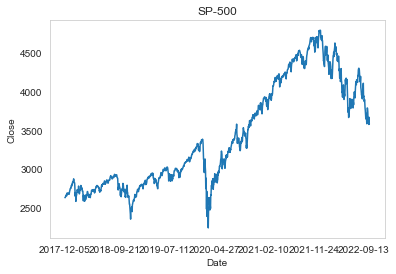

In [27]:
ax = TimeframeSP500['Close-0'].plot(title='SP-500')
ax.set_xlabel('Date')
ax.set_ylabel('Close')
ax.grid()
plt.show()

In [28]:
X = TimeframeSP500.iloc[:, :-1]

In [29]:
y = TimeframeSP500.iloc[:, -1]

In [30]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, shuffle = False)

### Padronização

In [31]:
# Score-Z

scaler = StandardScaler()

scaler.fit(X_treino)

X_treino = scaler.transform(X_treino)
X_teste = scaler.transform(X_teste)

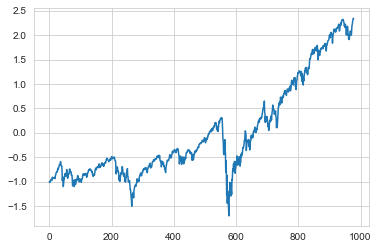

In [32]:
plt.plot(X_treino[:,-1]);

In [33]:
X_treino = X_treino.reshape((-1, steps, 1))
X_teste = X_teste.reshape((-1, steps, 1))

###  Construção, Treinamento e Avaliação do Modelo 1

In [34]:
# Callbacks
   
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose = verbose,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='loss',
                              factor=0.2,
                              patience=3,
                              mode="min",
                              verbose = verbose,
                              min_delta=0.00001,
                              min_lr=0)

callbacks = [tensorboard, earlystop, reduce_lr, TerminateOnNaN()]

In [35]:
def create_model(optimizer, layers, n_lstm, dropoutFoward):
     
    model = Sequential()
    
    model.add(LSTM(n_lstm,
                   activation = 'tanh',
                   recurrent_activation = 'sigmoid',
                   return_sequences = True,
                   input_shape = (steps, 1)))  

    
    #################################################################
    
    for layer in range(layers):
                
        model.add(Dropout(dropoutFoward))
        
        model.add(LSTM(n_lstm,
                       activation = 'tanh',
                       recurrent_activation = 'sigmoid',
                       return_sequences = True))  
    
    
    ##################################################################
    
    model.add(LSTM(n_lstm,
                   activation = 'tanh',
                   recurrent_activation = 'sigmoid',
                   return_sequences = False)) 
    
    
    model.add(Dense(1, activation = 'linear'))
    
    Lmse = keras.losses.MeanSquaredError()

    model.compile(loss= Lmse, optimizer=optimizer)

    return model

In [36]:
# Modelo

model = KerasRegressor(build_fn = create_model,
                        verbose = verbose,
                        callbacks = callbacks)

In [37]:
#Pipeline

estimator = Pipeline([("model", model)], verbose = verbose)

In [68]:
# Definição dos parametros (GridSearch)

# Optimizer
learning_rate = 0.01

opt_SGD = SGD(
    learning_rate = learning_rate,
    momentum = 0.0,
    nesterov = False)

opt_RMSprop = RMSprop(
    learning_rate = learning_rate,
    rho = 0.9,
    momentum = 0.0,
    epsilon = 1e-07,
    centered = False)

opt_Adam = Adam(
    learning_rate = learning_rate,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    amsgrad = False)

opt_Adadelta = Adadelta(
    learning_rate = learning_rate,
    rho = 0.95,
    epsilon = 1e-07)

opt_Adagrad = Adagrad(
    learning_rate = learning_rate,
    initial_accumulator_value = 0.1,
    epsilon = 1e-07)

opt_Adamax = Adamax(
    learning_rate = learning_rate,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07)

opt_Nadam = Nadam(
    learning_rate = learning_rate,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07)

opt_Ftrl = Ftrl(
    learning_rate = learning_rate,
    learning_rate_power = -0.5,
    initial_accumulator_value = 0.1,
    l1_regularization_strength = 0.0,
    l2_regularization_strength = 0.0,
    l2_shrinkage_regularization_strength = 0.0,
    beta = 0.0)

params_grid = {
    'model__optimizer': [opt_SGD, opt_RMSprop, opt_Adam, opt_Adadelta, opt_Adagrad, opt_Adamax, opt_Nadam, opt_Ftrl],  # [opt_SGD, opt_RMSprop, opt_Adam, opt_Adadelta, opt_Adagrad, opt_Adamax, opt_Nadam, opt_Ftrl]
    'model__layers': [3, 4, 5], # + 2 Por padrão já possui duas camadas LSTM
    'model__n_lstm': [50, 100],
    'model__dropoutFoward': [0, 0.1]
}

In [69]:
# Grid Search e Cross Validation

grid = GridSearchCV(estimator = estimator,
                    scoring = 'neg_mean_squared_error',
                    verbose = verbose,
                    return_train_score = False,
                    cv = nKFold,
                    # n_jobs = -2 # "-2": mantem 1 processador livre
                    # pre_dispatch = '2*n_jobs',
                    refit = True,
                    param_grid = params_grid)

In [70]:
# Monitoramento de Otimização

# tensorboard --logdir=logs/
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir logs (started 8:59:04 ago; port 6006, pid 31932).


In [41]:
# Treinamento

fit_params = {
    'model__batch_size': batch_size,
    'model__epochs': 1,#epochs,
    'model__verbose': verbose,
    'model__validation_data': (X_teste, y_teste),
    'model__shuffle': False,
    'model__validation_steps': None,
    'model__validation_freq': 1,
}

grid_result = grid.fit(X_treino, y_treino, **fit_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
25/25 - 17s - loss: 11219820.0000 - val_loss: 17938156.0000 - lr: 0.0100 - 17s/epoch - 682ms/step
[Pipeline] ............. (step 1 of 1) Processing model, total=  19.5s
7/7 - 2s - 2s/epoch - 289ms/step
[CV] END model__dropoutFoward=0, model__layers=3, model__n_lstm=100, model__optimizer=<keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x00000206A91EF5E0>; total time=  21.5s
25/25 - 15s - loss: 11202553.0000 - val_loss: 17868344.0000 - lr: 0.0100 - 15s/epoch - 599ms/step
[Pipeline] ............. (step 1 of 1) Processing model, total=  16.6s
7/7 - 2s - 2s/epoch - 284ms/step
[CV] END model__dropoutFoward=0, model__layers=3, model__n_lstm=100, model__optimizer=<keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x00000206A91EF5E0>; total time=  18.5s
25/25 - 14s - loss: 10856045.0000 - val_loss: 17906172.0000 - lr: 0.0100 - 14s/epoch - 555ms/step
[Pipeline] ............. (step 1 of 1) Processing model, total=  16.0s
7/

### Avaliação do Modelo

In [42]:
# Resultado do SearchGridCV

pd.concat([
           pd.DataFrame(grid.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_fit_time']],
           pd.DataFrame(grid.cv_results_['params'])
          ],
           axis=1,
           join='inner').set_index('rank_test_score').sort_values('rank_test_score')

# Função score com base no SearchGridCV

,mean_test_score,mean_fit_time,model__dropoutFoward,model__layers,model__n_lstm,model__optimizer
rank_test_score,,,,,,
1,-1.042542e+07,17.060268,0,3,100,<keras.optimizers.optimizer_v2.rmsprop.RMSprop...


In [43]:
best_params = grid.best_params_
best_model = grid.best_estimator_

In [44]:
# negative mean square error - Função score do Modelo Keras encapsulado
best_model.score(X_teste, y_teste)

8/8 - 0s - loss: 18127884.0000 - 188ms/epoch - 23ms/step


-18127884.0

In [45]:
# negative mean square error - Função score do Modelo Keras encapsulado
best_model.score(X_treino, y_treino)

31/31 - 0s - loss: 10443814.0000 - 472ms/epoch - 15ms/step


-10443814.0

In [56]:
def fillTableFrame(ativo, table = SP500_close):
    
    TimeframeTable = generatorTimeframeTable(table, ativo)
    
    for day in forecast:
        
        current_info = TimeframeTable.iloc[-1, 1:].to_numpy()
        
        standardCurrentInfo = current_info.reshape(1, steps, 1).astype('float32')
        
        #current_forecast = best_model.predict(scaler.transform(standardCurrentInfo), verbose=False).reshape(1,)
        
        current_forecast = best_model.predict(standardCurrentInfo, verbose=False).reshape(1,)
        
        new_line = np.concatenate((current_info, current_forecast), axis = 0)
        
        TimeframeTable = pd.concat([TimeframeTable,
                                    pd.DataFrame(new_line.reshape(1, -1),
                                                 columns = nameColumns,
                                                 index = [day])], axis = 0)
        
    return TimeframeTable

In [ ]:
############################################## Padronizar antes de prever

In [54]:
def fillTableFrame(ativo, table = SP500_close):
    
    TimeframeTable = generatorTimeframeTable(table, ativo)
    
    for day in forecast:
        
        current_info = TimeframeTable.iloc[-1, 1:].to_numpy()
        
        standardCurrentInfo = current_info.reshape(steps, 1)#.astype('float32')
        
        current_forecast = best_model.predict(scaler.transform(standardCurrentInfo).reshape(1, steps, 1), verbose=False).reshape(1,)
        
        #current_forecast = best_model.predict(standardCurrentInfo, verbose=False).reshape(1,)
        
        new_line = np.concatenate((current_info, current_forecast), axis = 0)
        
        TimeframeTable = pd.concat([TimeframeTable,
                                    pd.DataFrame(new_line.reshape(1, -1),
                                                 columns = nameColumns,
                                                 index = [day])], axis = 0)
        
    return TimeframeTable

In [ ]:
###############################################################

In [57]:
TimeframeSP500 = fillTableFrame('SP500', table = SP500_index)

In [58]:
# Cria tabela de Log-Retorno vazia 

tableRetLog = pd.DataFrame(index = TimeframeSP500.index,
                           columns = ativos).reset_index()#.rename(columns={'index': 'Dia'})

In [61]:
# Popula tabela de lOG-Retorno

lengthTable = len(tableRetLog)

for ativo in ativos:
    
    TimeframeSPAux = fillTableFrame(ativo)
    
    for n in range(len(forecast)):
        tableRetLog.loc[lengthTable-n-1, ativo] = \
        np.log(TimeframeSPAux.iloc[lengthTable-n-1, -1] / TimeframeSPAux.iloc[lengthTable-n-21, -1])

In [60]:
# Fim da tabela de Log-Retorno

tableRetLog.tail(21)

,index,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
1223,2022-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1224,2022-10-24,-2.756192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1225,2022-10-25,-2.73645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1226,2022-10-26,-2.723487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1227,2022-10-27,-2.706966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1228,2022-10-28,-2.699712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1229,2022-10-31,-2.690246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230,2022-11-01,-2.684495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1231,2022-11-02,-2.70158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1232,2022-11-03,-2.693362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# Gera tabela Intregável do Log-Retorno no padrão

tableRetLog.iloc[-20:, :].to_csv(path_or_buf = 'LogRetorno/SP500', index = False)

### Métricas

### Resíduos

## Conclusão